In [1]:
import osmnx as ox
import networkx as nx
import pandas as pd
import math

from rtree import index
from utils import *

In [3]:
place_name = "Paris, Ile-de-France, Metropolitan France, France"

# G = ox.graph_from_place(place_name, network_type='drive')
# ox.save_load.save_graphml(G, filename='Paris_drive.graphml', folder=None, gephi=False)

# G_whole = ox.graph_from_place(place_name)
# ox.save_load.save_graphml(G, filename='Paris_whole.graphml', folder=None, gephi=False)

G = ox.save_load.load_graphml(filename="Paris_drive.graphml", folder=None)

# Stores nodes and edges along with other attributes
type(G)

networkx.classes.multidigraph.MultiDiGraph

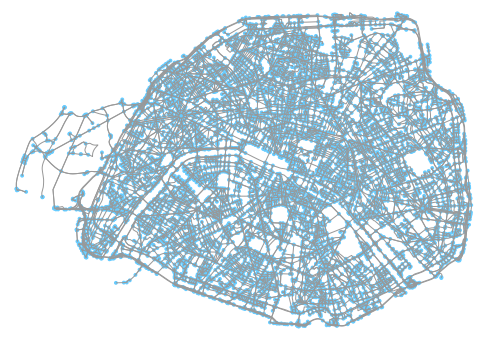

(<Figure size 952.984x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe27575b8d0>)

In [4]:
ox.plot.plot_graph(G)

In [5]:
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

In [6]:
nodes.head()

,y,x,osmid,highway,ref,geometry
5509971973,48.865456,2.391081,5509971973,NaN,NaN,POINT (2.39108 48.86546)
166297606,48.816421,2.360142,166297606,NaN,NaN,POINT (2.36014 48.81642)
271450120,48.875688,2.277891,271450120,NaN,NaN,POINT (2.27789 48.87569)
116129800,48.844563,2.287032,116129800,NaN,NaN,POINT (2.28703 48.84456)
116129802,48.843989,2.288553,116129802,NaN,NaN,POINT (2.28855 48.84399)


In [7]:
edges.head()

,u,v,key,osmid,name,highway,maxspeed,oneway,length,geometry,junction,bridge,lanes,service,tunnel,ref,access,width
0,5509971973,148942879,0,573814820,Rue Raoul Dufy,residential,30,False,35.570,"LINESTRING (2.39108 48.86546, 2.39113 48.86520...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,166297606,25240349,0,"[8059024, 362885203, 231974351]",NaN,trunk_link,50,True,311.127,"LINESTRING (2.36014 48.81642, 2.35993 48.81639...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,166297606,249076496,0,"[59942017, 85730575]",Avenue de la Porte d'Italie,primary,30,True,42.131,"LINESTRING (2.36014 48.81642, 2.36008 48.81631...",circular,yes,3,NaN,NaN,NaN,NaN,NaN
3,271450120,27339859,0,28686364,NaN,trunk_link,50,True,96.693,"LINESTRING (2.27789 48.87569, 2.27810 48.87564...",NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
4,271450120,442306,0,325868307,Rue du Général Anselin,tertiary,50,True,103.415,"LINESTRING (2.27789 48.87569, 2.27821 48.87553...",NaN,NaN,2,NaN,NaN,NaN,NaN,NaN


In [8]:
def process_edges(edges):
    ### Process maxspeed first
    ## Remove list and null values from maxspeed
    i = 0
    for x in edges['maxspeed']:
        if type(x) == list:
            edges['maxspeed'][i] = max(x)
        elif type(x) == float or x == 'FR:urban':
            edges['maxspeed'][i] = 80
        i += 1           
        
    ## Change to float
    edges['maxspeed'] = edges['maxspeed'].astype(float)
    
    ### Define free-flow time t(u,v) in sec
    edges['free_flow_time'] = [(3600*l)/(1000*s) for (l,s) in zip(edges['length'], edges['maxspeed'])]
    
    
    ### Define estimated time (Gaussian)
    estimated_time = []
    n = len(edges['u'])

    for i in range(n):
        ff = float(edges['free_flow_time'][i])
        est_time = 2*ff*math.sqrt(2/math.pi)
        estimated_time.append(est_time)

    edges['ETA'] = estimated_time
    
    ### Define capacity for Frank-Wolfe
    capacity = []
    n = len(edges['u'])

    for i in range(n):
        l = edges['length'][i]
        k = float(edges['key'][i])
        c = math.ceil(3 * (1 + k) * l / 6) #Take width as 3m and size of car+spacing as 6m
        capacity.append(c)

    edges['capacity'] = capacity    
    
    ### Drop unnecessary columns
    edges.drop(['lanes','bridge','ref','access','junction','tunnel','width','service'], axis=1, inplace=True)
    

In [9]:
process_edges(edges)
edges.head()

/home/orionstar25/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/orionstar25/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,u,v,key,osmid,name,highway,maxspeed,oneway,length,geometry,free_flow_time,ETA,capacity
0,5509971973,148942879,0,573814820,Rue Raoul Dufy,residential,30.0,False,35.570,"LINESTRING (2.39108 48.86546, 2.39113 48.86520...",4.268400,6.811381,18
1,166297606,25240349,0,"[8059024, 362885203, 231974351]",NaN,trunk_link,50.0,True,311.127,"LINESTRING (2.36014 48.81642, 2.35993 48.81639...",22.401144,35.747054,156
2,166297606,249076496,0,"[59942017, 85730575]",Avenue de la Porte d'Italie,primary,30.0,True,42.131,"LINESTRING (2.36014 48.81642, 2.36008 48.81631...",5.055720,8.067762,22
3,271450120,27339859,0,28686364,NaN,trunk_link,50.0,True,96.693,"LINESTRING (2.27789 48.87569, 2.27810 48.87564...",6.961896,11.109579,49
4,271450120,442306,0,325868307,Rue du Général Anselin,tertiary,50.0,True,103.415,"LINESTRING (2.27789 48.87569, 2.27821 48.87553...",7.445880,11.881905,52


In [10]:
G = ox.gdfs_to_graph(nodes, edges)

In [11]:
ox.save_load.save_graphml(G, filename='Paris_processed.graphml', folder=None, gephi=False)
# To convert to .osm for CH
ox.save_load.save_graph_shapefile(G, filename='paris')

## Make tntp files

In [27]:
make_nodes_tntp(nodes, 'data/Paris_node.tntp')

### Off-peak

In [29]:
make_net_tntp(edges, 'data/Paris_net_off.tntp')

### High-peak

In [30]:
# Reduce capacity by 50%
reduced_capacity = [math.floor(float(x)/2) for x in edges['capacity']]
edges['capacity'] = reduced_capacity
make_net_tntp(edges, 'data/Paris_net_high.tntp')

## Make demand file (500 customers)

In [12]:
# get 10 sources from central SG
sources = nodes['osmid'].values[:10]
 
# get 10 targets from central SG
targets = nodes['osmid'].values[-10:]

In [13]:
# Fill in all nodes to find neighbours
# key: node label ,value: location
idx = index.Index()

xx = nodes['x'].astype(float)
yy = nodes['y'].astype(float)
node_id = nodes['osmid']

for node, x, y in zip(node_id, xx, yy):
    idx.insert(int(node), (x,y,x,y))

In [14]:
demands = []
for s in sources:
    for t in targets:
        demands.append([s,t])

In [34]:
make_trips_tntp(demands, "data/Paris_trips_500.tntp")

No. of requests:  500


## Make demand file for middle mile (500 customers)

In [22]:
def bingo(sources, targets): 
    demand = []    
    count = 0
    
    for s in sources:
        for t in targets:
            orig_point = nodes[nodes['osmid'] == int(s)].geometry.values[0]
            target_point = nodes[nodes['osmid'] == int(t)].geometry.values[0]
            orig_xy = (orig_point.y, orig_point.x)
            target_xy = (target_point.y, target_point.x)

            # Find all nodes within 500m from candidate sources and destinations
            candidate_dest = find_nearest_nodes(nodes, target_xy, 450, idx)
            candidate_source = find_nearest_nodes(nodes, orig_xy, 450, idx)
#             print(len(candidate_dest)*len(candidate_source))

            euclidean = get_length_dict(nodes, candidate_source, candidate_dest)        
            OD = modified_hybrid_search(nodes, euclidean)
            demand.append(OD)
            count += 1
            print(count)
            
    return demand

In [16]:
G_whole = ox.save_load.load_graphml(filename="Paris_whole.graphml", folder=None)

### Off-peak

In [23]:
transits_off = bingo(sources, targets)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [24]:
ped_off = []
ctr = 0

for s in sources:
    for t in targets:
        first = nx.dijkstra_path_length(G_whole, s, transits_off[ctr][0], weight='length')/5.55
        last = nx.dijkstra_path_length(G_whole, transits_off[ctr][1], t, weight='length')/5.55
        ped_off.append(first+last)   

In [25]:
import pickle
with open('data/ped.pkl', 'wb') as fp:
    pickle.dump(ped_off, fp)

In [26]:
make_trips_tntp(transits_off, filename="data/Paris_system_trips.tntp")

No. of requests:  500
